# Erdös-Rényi method for random graphs
*by Roberto Esteban López*

In this work, an implementation of a python class and evaluation is done to test the Giant Component analysis on the random graphs generated with the method of Erdös-Rényi as proposed on their work [1]. In which, given a fixed number of vertex $n$ and a probility $p$ of including one of the ${n\choose 2}$ edges per vertex. The graphs are generated and stored in as an object class *UGraph* with adjancency list form, then as a method for the class there's a breadth-first search(BFS) which only result is the number of vertex reached by a random start BFS.

In [1]:
import numpy as np
import numpy.random as rdm

In [2]:
class UGraph:
    # Graphs are generated in adjacency lists. Each index of the list correpond to the same index of the node of the graph. And the contents of the list
    # are the nodes to which the node is connected.
    # Suppose is a undirected graph.

    def __init__(self, n, p):
        if n < 2:
            raise Exception('Nodes need to be greater than 2')
            n = 2
        self.nodes_len = n
        self.p = p
        self.nodes = []
        self.G, self.G_deg = self.gen_random_graph(n,p)
        self.index = 0
        self.convex = False
        if n == self.BFS(self.G):
            self.convex = True

    def gen_random_graph(self, n, p):
        G = []
        cards = [] # Cardinality of each nodes or degree
        self.nodes = [i for i in range(n)]
        
        for node in self.nodes:
            new_edges = []
            card = 0
            for i in self.nodes:
                if i == node:
                    None # No autoconnections allowed
                elif p >= rdm.random_sample():
                    new_edges.append(i)
                    card += 1
            G.append(new_edges)
            cards.append(card)
            
        return (G, cards)
    
    def __iter__(self):
        return self
    def __next__(self):
        if self.index == self.nodes_len:
            raise StopIteration
        i = self.index
        self.index += 1
        return (i, self.G[i], self.G_deg[i])
    # Returning the actual node, the nodes where it goes to and the degree of those
    def __repr__(self):
        return 'Undirected graph with {0} nodes. Convexity {1}'.format(self.nodes_len,self.convex)
    
    @staticmethod
    def BFS(T, s=None, ls=None):
        # T is the graph to discover. It can be feed as a adjacency list for indexes from 0 to nodes - 1
        # S is the starting node, is None, then takes the first item of T
        # ls is the number of nodes 
        if ls == None:
            ls = len(T)
        if s == None:
            s = 0
        discovered = np.zeros(ls, dtype=np.bool_)
        discovered[s] = True
        BFS_len = 1
        L = [s]
        while L != []:
            L_1 = []
            for u in L:
                for v in T[u]:
                    if not discovered[v]:
                        discovered[v] = True
                        L_1.append(v)
                        BFS_len += 1
            L = L_1
        return BFS_len

The next is the test of the implementation looking with fixed probabilities of the Giant component; another way to see it is that the graph is convex or not, of random graphs of some $n$ quantities.

In [3]:
from multiprocessing import Pool

def evaluate_graph(n, pr, i, workers=-1):
    """
    This function creates a random graph
    with the arguments n, pr with the method
    of Erdos-Renyi.
    Then it evaluates if the graph is convex.
    This repeats i times. Can be used in parallel
    evaluations giving a certain number of workers.
    Use workers = -1 to use all the available cpu 
    threads to python.
    """
    if (workers < 0) or (workers > os.cpu_count()):
        workers = os.cpu_count()
    P = Pool(processes=workers)
    # Evaluating a sample in individual threads. As they are unrelated.
    results = P.map(evaluate_graph_sub, [(n,pr) for _ in range(i)])
    # Close the pool of processes
    P.close()
    P.join()
    positives = np.mean(results)
    #print(pr, positives)
    return positives

def evaluate_graph_sub(SS):
    # Just and auxiliar function that generates a 
    # random graph and sees if it's convex
    n, p = SS
    graph = UGraph(n,p)
    if graph.convex:
        return 1
    else:
        return 0

Now, the results are generated with the previous code. In jupyter notebooks the multiprocessing library has an ill behaviour or does not execute at all. So the all previous code is writen to a .py file and imported as *myRandom*. 

The test is done with different quantity of nodes for the graphs and the critical probabilities where the chances of having isolated nodes. Which comes from the following theorem [2]:

**Theorem:** Suppose $p = p_n = \log(n)/n + c/n$ where $c$ is an arbitary real constant. Then the number of isolated vertices of the random graph $G_{n,p}$ is governed asymptotically by a Poisson distribution with parameter $e^{-c}$. A fortiori, the probability that there exist isolated vertices in $G_{n,p}$ tends to $1-e^{e^{-c}}$ as $n \rightarrow \infty$.

In [4]:
from tqdm import tqdm
import ra_hw4_v1 as myRandom
iterations = 10
n_test = np.linspace(10**2, 10**4, num=3, dtype=np.int32)
c_s = np.linspace(-4, 6, num=8)
p_test = np.zeros((len(c_s),len(n_test)))
for i in range(p_test.shape[0]):
    for j in range(p_test.shape[1]):
        n = n_test[j]
        c = c_s[i]
        p_test[i,j] = np.log(n)/n + c/n
results = np.zeros(p_test.shape)

In [5]:
for i_n in tqdm(range(len(n_test))):
    for i_p in range(p_test.shape[0]):
        results[i_p, i_n] = myRandom.evaluate_graph(n_test[i_n], 
                                                    p_test[i_p, i_n],
                                                   iterations,
                                                   workers = iterations)

100%|██████████| 3/3 [1:04:28<00:00, 1289.59s/it]


The results shown in this notebook are costly to calculate even with the parallel application, due to python language and whatnot. It tooks around 70 min to execute on a multithreaded Ryzen 5 @ 3.7 GHz. Memory wise it does not exceds the 500 Mb with 12 threads active.

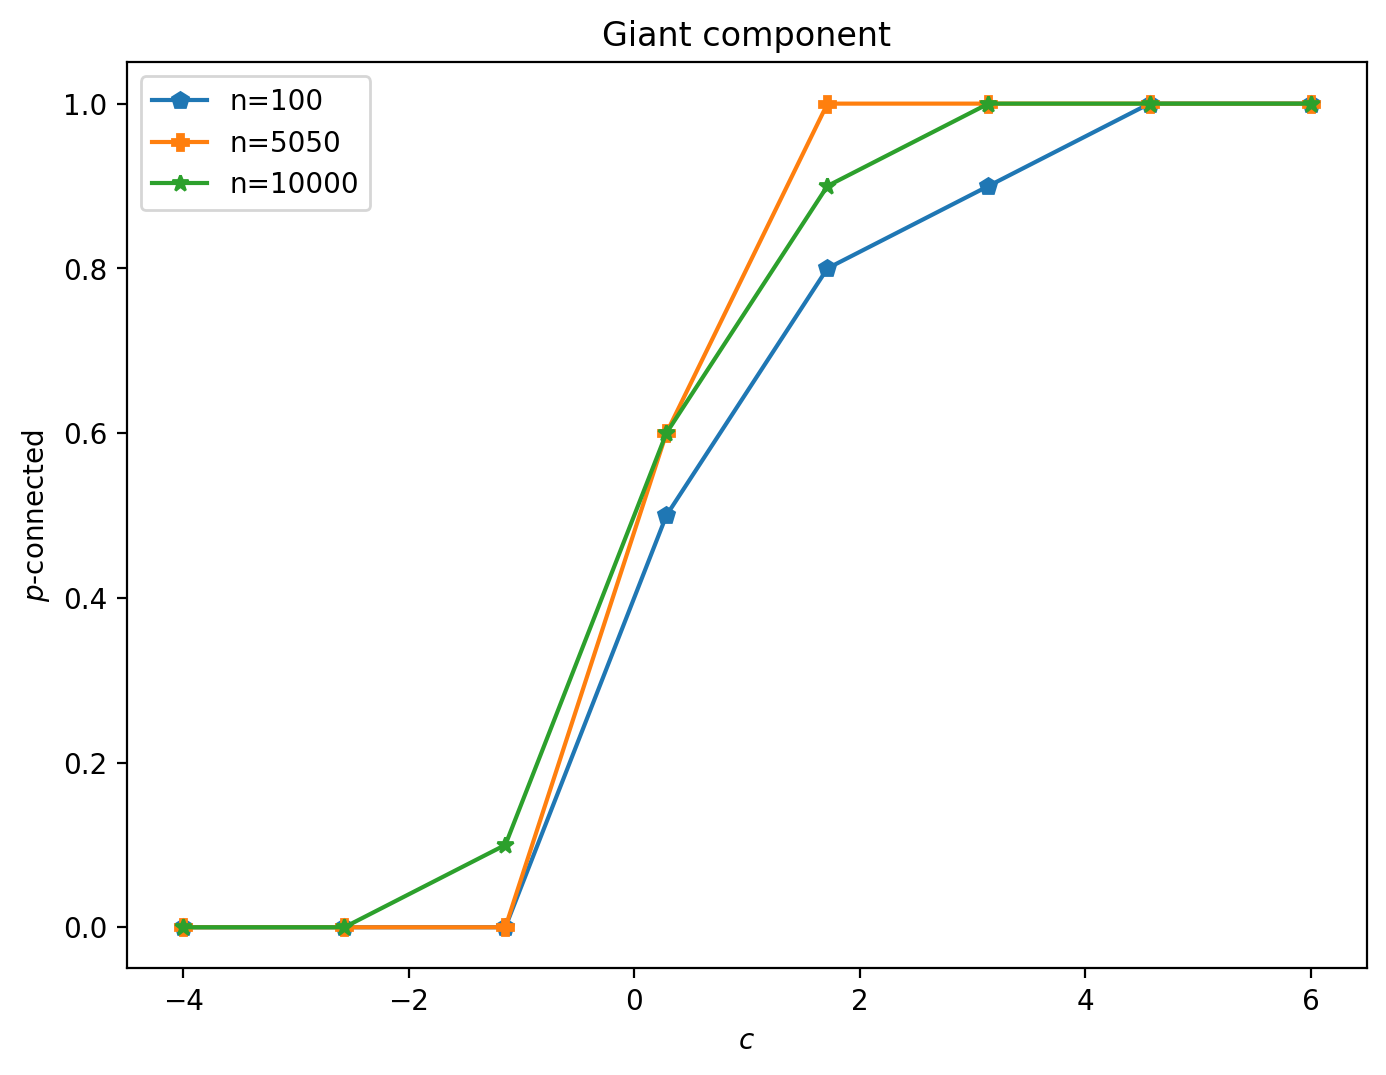

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6),dpi=200)
mar = ["p", "P", "*", "s"]
for i in range(len(n_test)):
    plt.plot(c_s, results[:,i], label="n={}".format(n_test[i]),marker=mar[i])
plt.xlabel("$c$")
plt.ylabel("$p$-connected")
plt.title("Giant component")
plt.legend()
plt.show()

As the graph shows, there is a notable jump on the probality or change of phase on with respect to $c$ even with multiple sizes of the random graphs. This following the behaviour of double expotential drop of probability $e^{-e^{-c}}$, which makes very unlikely to generate isolated vertex on the random graph once $c$ gets large enough. 

## References
- Erdős, P.; Rényi, A. (1959). "On Random Graphs. I". Publicationes Mathematicae. 6: 290–297
- Mitzenmacher, M., & Upfal, E. (2017). Probability and computing: Randomization and probabilistic techniques in algorithms and data analysis. Cambridge university press. 143